# Ermine Tutorial 06
## Simulate single-particle tracking data with ermine

by Sebastian Malkusch (c) 2021  
malkusch@med.uni-frankfurt.de  
Data Science| Klinische Pharmakologie  
Institut für Klinische Pharmakologie  
Goethe - Universität  
Theodor-Stern-Kai 7  
60590 Frankfurt am Main

## Abstarct
In this tutorial, we demonstrate how to perform in-silico single-particle tracking experiments using the ermine package.

## Prerequisite
Nothing

## Import libraries
You need to install Ermine prior to usage.  
Run  
python -m pip install git+https://github.com/SMLMS/pyErmine  
from the command line 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ermine as em
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from math import sin, cos, radians, pi
from string import ascii_lowercase

## Define experimental parameters
* define mobility modes for the model: priorModel_components  
* define time interval between two measurements : $\tau$  
* define degrees of freedom for translational movement: dof
* define mobility mode weights
* define transition probabilities
* define diffusion coefficients
* calculate expected mean squared displacements

In [2]:
model_components = 3
tau = 0.02
dof = 4
weights = np.array([0.2, 0.3, 0.5])

transition_probabilities = em.init_transition_matrix(n_components = model_components, stability = 0.9)

diffusion_coefficients = np.array([[ 17000],
                                   [ 65000],
                                   [170000]])

mu = em.postprocessing.calculate_expectation_value(diff_coeff = diffusion_coefficients,
                                                   tau = tau,
                                                   dof = dof,
                                                   sigma = 0, # We do not expect any errors in this tutorial
                                                   epsilon = 0)# We do not expect any errors in this tutorial

print("done")

done


## Set up HMM

In [3]:
hmm = em.ErmineHMM(n_components = model_components,
                   diffusion_degrees_of_freedom = dof,
                   tau = tau)
    
hmm.startprob_ = weights
hmm.transmat_ = transition_probabilities
hmm.diffusion_coefficients_ = diffusion_coefficients
print("done")

done


## Simulate jumps
Single-particle jump data are simulated using Monte Carlo methods.  
This step is time consuming. Maybe grab a cup of coffee.

In [4]:
def localization_coordinate(x0, y0, r, alpha):
    alpha_rad = pi/2 - radians(alpha)
    return x0 + r*cos(alpha_rad), y0 + r*sin(alpha_rad)

def estimate_coordinates(r, max_r = 20000.0):
    x_departure = np.zeros(np.shape(r)[0])
    y_departure = np.zeros(np.shape(r)[0])
    x_destination = np.zeros(np.shape(r)[0])
    y_destination = np.zeros(np.shape(r)[0])
    alpha0 = np.random.uniform(low=0.0, high=360.0, size=1)
    r0 = np.random.uniform(low=0.0, high=max_r, size=1)
    x_departure[0], y_departure[0] = localization_coordinate(x0=0, y0=0, r=r0, alpha=alpha0)
    alpha = np.random.uniform(low=0.0, high=360.0, size=np.shape(r)[0])
    x_destination[0], y_destination[0] = localization_coordinate(x_departure[0], y_departure[0], r[0], alpha[0])
    x_departure[1] = x_destination[0]
    y_departure[1] = y_destination[0]
    for i in np.arange(1,np.shape(r)[0]-1,1):
        x_destination[i], y_destination[i] = localization_coordinate(x_departure[i], y_departure[i], r[i], alpha[i])
        x_departure[i+1] = x_destination[i]
        y_departure[i+1] = y_destination[i]   
    return(x_departure, y_departure, x_destination, y_destination)
    

seed = 42
np.random.seed(seed)
n_particles = 10
t_max = 100
sample_df = pd.DataFrame({"x_departure":[],
                          "y_departure": [],
                          "x_destination":[],
                          "y_destination": [],
                          "r": [],
                          "state":[],
                          "D": [],
                          "particle": [],
                          "time": []})
for i in range(n_particles):
    x_hmm, state_sequence = hmm.sample(n_samples=t_max, random_state=seed+i)
    x_departure, y_departure, x_destination, y_destination = estimate_coordinates(x_hmm[:,0])
    temp_df = pd.DataFrame({"x_departure": x_departure/1000.0, 
                            "y_departure": y_departure/1000.0,
                            "x_destination": x_destination/1000.0,
                            "y_destination": y_destination/1000.0,
                            "r": x_hmm[:,0],
                            "state": state_sequence,
                            "D": np.take(diffusion_coefficients, state_sequence),
                            "particle": np.repeat(i, t_max),
                            "time": np.arange(t_max)*tau
                           })
    sample_df = sample_df.append(temp_df).copy()
sample_df = sample_df.astype({"x_departure": "float",
                              "y_departure": "float",
                              "x_destination":"float",
                              "y_destination": "float",
                              "r": "float",
                              "state": "int",
                              "D": "float",
                              "particle": "int",
                              "time": "float"}).copy()

sample_df = sample_df[sample_df["time"]<tau*(t_max-1)].copy()
sample_df.head()

,x_departure,y_departure,x_destination,y_destination,r,state,D,particle,time
0,13.483924,-13.406225,13.359614,-13.420349,125.110477,1,65000.0,0,0.00
1,13.359614,-13.420349,13.319586,-13.476430,68.900662,1,65000.0,0,0.02
2,13.319586,-13.476430,13.344254,-13.459896,29.696813,1,65000.0,0,0.04
3,13.344254,-13.459896,13.429194,-13.402943,102.266321,1,65000.0,0,0.06
4,13.429194,-13.402943,13.457752,-13.328197,80.015625,1,65000.0,0,0.08


## Save simulation result
Transform sample_df to a single-particle tracking file and save it to the results folder.

In [5]:
out_file_name = str("results/simulation_n%i_dt%i.csv" %(n_particles, t_max))
spt_df = sample_df[sample_df["time"]<tau*(t_max-1)][["x_departure", "y_departure", "time", "particle", "state"]].copy()
spt_df = spt_df.rename(columns = {"x_departure": "x", "y_departure": "y"})
spt_df.to_csv(out_file_name)
spt_df.head()

,x,y,time,particle,state
0,13.483924,-13.406225,0.00,0,1
1,13.359614,-13.420349,0.02,0,1
2,13.319586,-13.476430,0.04,0,1
3,13.344254,-13.459896,0.06,0,1
4,13.429194,-13.402943,0.08,0,1


## Plot simulation

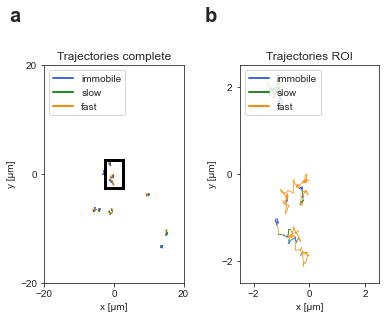

In [6]:
sns.set_style("ticks")
fig, axs = plt.subplots(1,2)
custom_lines = [Line2D([0], [0], color="#4169e1", lw=2),
                Line2D([0], [0], color="#228b22", lw=2),
                Line2D([0], [0], color="#ff8c00", lw=2)]
# =============================================================================
# viterbi plot full
# =============================================================================
state_df = sample_df[sample_df["state"]== 2].copy()
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[0].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#ff8c00")
state_df = sample_df[sample_df["state"]== 1].copy()
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[0].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#228b22")
state_df = sample_df[sample_df["state"]== 0].copy()    
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[0].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#4169e1")

axs[0].add_patch(Rectangle((-2.5, -2.5), 5, 5,
                            edgecolor = 'black',
                            zorder = 1000000,
                            fill=False,
                            lw=3))

axs[0].legend(custom_lines, ['immobile', 'slow', 'fast'], loc='upper left', fontsize=10)
axs[0].set_title("Trajectories complete")
axs[0].set_xlabel("x [\u03bcm]")
axs[0].set_ylabel("y [\u03bcm]")
axs[0].set_xlim(-20, 20)
axs[0].set_ylim(-20, 20)
axs[0].locator_params(axis = 'both', nbins=3)
axs[0].text(-0.25, 1.2, ascii_lowercase[0],
            transform=axs[0].transAxes,
            size=20, weight='bold')

# =============================================================================
# viterbi plot roi
# =============================================================================
search_string = " ".join(("x_departure > -2.5 and",
                          "x_departure < 2.5 and",
                          "x_destination > -2.5 and",
                          "x_destination < 2.5 and",
                          "y_departure > -2.5 and",
                          "y_departure < 2.5 and",
                          "y_destination > -2.5 and",
                          "y_destination < 2.5"))

roi_df = sample_df.query(search_string, inplace = False).copy()

state_df = roi_df[roi_df["state"]== 2].copy()
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[1].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#ff8c00")
state_df = roi_df[roi_df["state"]== 1].copy()
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[1].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#228b22")
state_df = roi_df[roi_df["state"]== 0].copy()    
for j in np.arange(state_df.shape[0]):
    jump = state_df.iloc[j]
    axs[1].plot(np.array([jump['x_departure'], jump['x_destination']]),
                np.array([jump['y_departure'], jump['y_destination']]),
                lw=0.75,
                color="#4169e1")


axs[1].legend(custom_lines, ['immobile', 'slow', 'fast'], loc='upper left', fontsize=10)
axs[1].set_title("Trajectories ROI")
axs[1].set_xlabel("x [\u03bcm]")
axs[1].set_ylabel("y [\u03bcm]")
axs[1].set_xlim(-2.5, 2.5)
axs[1].set_ylim(-2.5, 2.5)
axs[1].locator_params(axis = 'both', nbins=3)
axs[1].text(-0.25, 1.2, ascii_lowercase[1],
            transform=axs[1].transAxes,
            size=20, weight='bold')      

plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.4,
                    hspace=0.5)
plt.show()